In [14]:
import numpy as np
import center_algorithms as ca
import matplotlib.pyplot as plt

Tests with MNIST 2s and 5s.

#### To Do

    -Comment last few blocks of code

In [15]:
'''
This function verifies that we found a local optimizer for
the sine median or maximum cosine problem.
It does this by checking 100 points around the optimizer.

Inputs: 
    optimizer- a numpy array that represente the suggested optimizer
    opf_fn- a string, 'sine' for sine median and 'cosine' for maximum cosine
    data- a list of numpy arrays representing points on grassmannians
Outputs:
    local optimizer- True if all checked points result in objective function values
                        that are greater than the Sine Median problem or smaller than
                        the Maximum Cosine value
'''
def sanity_check(optimizer, opt_fn, data):
    
    n,r = optimizer.shape
    
    
    #objective function value for suggested optimizer
    sln_val = ca.calc_error_1_2(data, optimizer, opt_fn) 
    
    #stays true if optimizer is a local min
    local_optimizer = True

    #checking random points
    perturb_vals = []
    for i in range(100):
        
        #random points between -.5 and .5 times .01
        perturb = (np.random.rand(n,r)-5)*.01 
        perturb_check = np.linalg.qr(perturb + optimizer)[0][:,:r]
        
        #check objective function value
        perturb_vals.append(ca.calc_error_1_2(data, perturb_check, opt_fn))

        if opt_fn == 'sine':
            if perturb_vals[i] < sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to minimizer')
        elif opt_fn == 'cosine':
            if perturb_vals[i] > sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to maximizer')
    return local_optimizer

In [16]:
'''
Shannon Stiverson's dataloader

Inputs:
    digits- list or int for digits from MNIST to be samples
    sample_size - number of samples of that digit
    dset - 'train' or 'test' for sampling from the training or the test datasets
Outputs:
    out_datamat - a numpy array of dimensions (784 x sample_size)
    datamat_labels - a list of labels of the sampled points
'''

def load_mnist_data(digits, sample_size=100, dset='train', shuffle = False):

    if type(digits) == int:
        digits = [digits]

    if type(sample_size) == int:
        sample_size = [sample_size]*len(digits)

    if len(sample_size) != len(digits):
        print('Incorrect number of sample sizes given.')
        return [], []

    return_data = []
    return_labels = []

    for i in range(len(digits)):
        digit = digits[i]
        size = sample_size[i]
        digit_data = np.loadtxt('../MNIST/%s%i.csv' % (dset, digit), delimiter=',')
        if digit_data.shape[1] < size:
            print('Sample number for digit %i reduced to %i' % (digit, digit_data.shape[1]))
            return_data.append(digit_data)
            return_labels.append([digit]*digit_data.shape[1])
        else:
            if shuffle:
                idx = np.random.choice(np.arange(digit_data.shape[1]), size)
            else:
                idx = np.arange(size)
            return_data.append(digit_data[idx, :])
            return_labels.append([digit]*size)

    datamat = return_data[0]
    datamat_labels = return_labels[0]

    if len(digits) > 1:
        for i in range(1, len(digits)):
            datamat = np.vstack((datamat, return_data[i]))
            datamat_labels = np.hstack((datamat_labels, return_labels[i]))

    out_datamat = datamat.T
    
    return out_datamat, datamat_labels


In [17]:
'''
calculates Flag Mean, Maximum Cosine and Sine Median for a dataset

Inputs:
    k- int for Gr(k,784)
    num_samples2- int for number of samples of 2s
    num_samples5- int for number of samples of 5s
    n_its- integer for the number of iterations of FlagIRLS
    seed- int for numpy random initialization
Outputs:
    flagmean- numpy array that represents Flag Mean of gr_list
    sin_median- numpy array that represents Sine Median of gr_list
    max_cosine- numpy array that represents Max Cosine of gr_list
    gr_list- dataset as subspaces in Gr(k,748)
'''
def run_test(k,num_samples2,num_samples5,n_its,seed):
    
    data_matrix2 = load_mnist_data(2, k*num_samples2, dset='train')[0]
    data_matrix5 = load_mnist_data(5, k*num_samples5, dset='train')[0]

    gr_list = []
    for i in range(num_samples2):
        #TODO: make sure we're taking more than one two
        if k==1:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])

    for i in range(num_samples5):
        if k==1:
            point = data_matrix5[:,i*k:(i+1)*k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])
            
    
    flagmean = ca.flag_mean(gr_list, k, fast = False)
    print('Flag Mean finished')

    #calculate sine median
    sin_median, s_err = ca.irls_flag(gr_list, k, n_its, 'sine', opt_err = 'sine', fast = False, seed = seed)
    print('Sine Median finished')
    
#     #for debugging
#     plt.figure()
#     plt.plot(s_err)
#     plt.title('sine error')

    #calculate maximum cosine
    max_cosine, c_err = ca.irls_flag(gr_list, k, n_its, 'cosine', opt_err = 'cosine', fast = False, seed = seed)
    print('Max Cos finished')
    
#     #for debugging
#     plt.figure()
#     plt.plot(c_err)
#     plt.title('cosine error')
    
    if k==1:
        #calculate geodesic median
        geodesic_median, g_err = ca.irls_flag(gr_list, k, n_its, 'geodesic', opt_err = 'geodesic', fast = False, seed = seed)
        print('Geodesic finished')

        return flagmean, sin_median, max_cosine, geodesic_median, gr_list
    
    else:
        return flagmean, sin_median, max_cosine, gr_list

In [18]:
'''
creates an image of the plot_k row of each Y in Ys

Inputs:
    title- string for the plot title
    Ys- list of numpy arrays to be plotted
    plot_k - column to plot

Outputs:
    none
'''
def plot_results(title, Ys, plot_k, n2s, n5s):
    ii=0
    for Y in Ys:
        plt.figure()
        plt.title(title+' '+str(n2s[ii])+' twos and '+str(n5s[ii])+' fives')
        plt.imshow(Y[:,plot_k].reshape(28,28), cmap = 'gray')
        plt.axis('off')
        ii+=1

In [19]:
def calc_min_angle(X, Y):
    return np.arccos(np.linalg.svd(X.T @ Y)[1][-1])

In [20]:



k = 1 #Gr(k,n)
num_samples2 = 20 #number of samples of the 2 digit
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 1 #samples 5s from 0 to num_samples2 in increments of incr

plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS

if num_samples2 % incr != 0:
    print('incr does not divide num_samples2 evenly!')

In [21]:

flagmeans = []
sin_medians = []
max_cosines = []
geo_medians = []
n2s  = []
n5s = []

for num_samples5 in range(0,num_samples2,incr):
    out = run_test(k,num_samples2,num_samples5,n_its,seed)
    flagmeans.append(out[0])
    sin_medians.append(out[1])
    max_cosines.append(out[2])
    if k == 1:
        geo_medians.append(out[3])
    n2s.append(num_samples2)
    n5s.append(num_samples5)
if k == 1:
    dataset = out[4]
else:
    dataset = out[3]

Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine Median finished
Max Cos finished
Geodesic finished
Flag Mean finished
Sine M

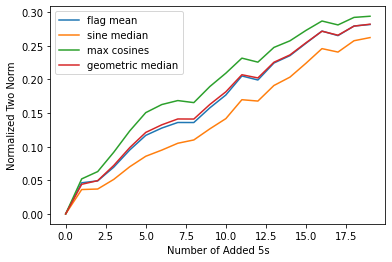

In [22]:
num_tests = num_samples2//incr
#differences from 0
flagmean_diffs = []
sin_medians_diffs = []
max_cosines_diffs = []
geo_medians_diffs = []
for ii in range(num_tests):
    flagmean_diffs.append(np.linalg.norm(flagmeans[ii] - flagmeans[0])/np.linalg.norm(flagmeans[0]))

    sin_medians_diffs.append(np.linalg.norm(sin_medians[ii] - sin_medians[0])/np.linalg.norm(sin_medians[0]))
    
    max_cosines_diffs.append(np.linalg.norm(max_cosines[ii] - max_cosines[0])/np.linalg.norm(max_cosines[0]))
    
    
    geo_medians_diffs.append(np.linalg.norm(geo_medians[ii] - geo_medians[0])/np.linalg.norm(geo_medians[0]))

xs = [i for i in range(0,num_samples2,incr)]
plt.plot(xs, flagmean_diffs, label = 'flag mean')
plt.plot(xs, sin_medians_diffs, label = 'sine median')
plt.plot(xs, max_cosines_diffs, label = 'max cosines')
plt.plot(xs, geo_medians_diffs, label = 'geometric median')
plt.xlabel('Number of Added 5s')
plt.ylabel('Normalized Two Norm')
plt.legend()


0.0
0.046302059726936066
0.04913879244698009
0.06950807203422985
0.09509702062251264
0.11685669796739048
0.1277442701373983
0.13604748117255158
0.1359908593879057
0.15786913995002835
0.17706789280143323
0.20548307496168008
0.19944546358988016
0.22483402072141925
0.23588299043515956
0.25441304054168123
0.27272471212191624
0.26589023288911456
0.2803356899099528
0.2825721698813475


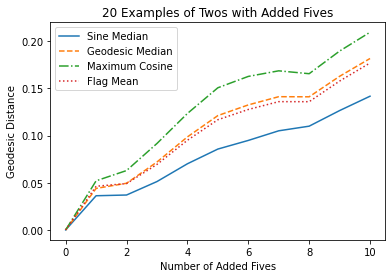

In [58]:
num_tests = num_samples2//incr
#differences from 0
flagmean_diffs = []
sin_medians_diffs = []
max_cosines_diffs = []
geo_medians_diffs = []
for ii in range(num_tests):
    print(ca.calc_error_1_2([flagmeans[ii]],flagmeans[0],'geodesic'))
    flagmean_diffs.append(ca.calc_error_1_2([flagmeans[ii]],flagmeans[0],'geodesic'))

    sin_medians_diffs.append(ca.calc_error_1_2([sin_medians[ii]],sin_medians[0],'geodesic'))
    
    max_cosines_diffs.append(ca.calc_error_1_2([max_cosines[ii]],max_cosines[0],'geodesic'))
    
    geo_medians_diffs.append(ca.calc_error_1_2([geo_medians[ii]],geo_medians[0],'geodesic'))

xs = [i for i in range(0,11,incr)]

plt.plot(xs, sin_medians_diffs[:11], label = 'Sine Median')
plt.plot(xs, geo_medians_diffs[:11], label = 'Geodesic Median', linestyle = 'dashed')
plt.plot(xs, max_cosines_diffs[:11], label = 'Maximum Cosine', linestyle = 'dashdot')
plt.plot(xs, flagmean_diffs[:11], label = 'Flag Mean', linestyle = 'dotted')
plt.xticks([0,2,4,6,8,10])
plt.title(str(num_samples2)+' Examples of Twos with Added Fives')
plt.xlabel('Number of Added Fives')
plt.ylabel('Geodesic Distance')
plt.legend()


/var/folders/xg/_sqbz6jj3fgdczbxm1zpp0nc0000gp/T/ipykernel_1921/1011967500.py:2: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.linalg.svd(X.T @ Y)[1][-1])


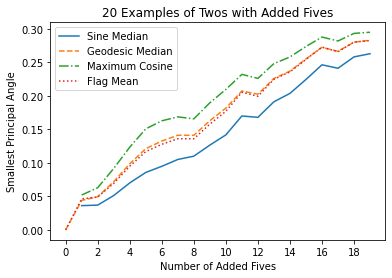

In [24]:
num_tests = num_samples2//incr
#differences from 0
flagmean_diffs = []
sin_medians_diffs = []
max_cosines_diffs = []
geo_medians_diffs = []
for ii in range(num_tests):
#     print(ca.calc_error_1_2([flagmeans[ii]],flagmeans[0],'geodesic'))
    flagmean_diffs.append(calc_min_angle(flagmeans[ii],flagmeans[0]))

    sin_medians_diffs.append(calc_min_angle(sin_medians[ii],sin_medians[0]))
    
    max_cosines_diffs.append(calc_min_angle(max_cosines[ii],max_cosines[0]))
    
    geo_medians_diffs.append(calc_min_angle(geo_medians[ii],geo_medians[0]))

xs = [i for i in range(0,num_samples2,incr)]

plt.plot(xs, sin_medians_diffs, label = 'Sine Median')
plt.plot(xs, geo_medians_diffs, label = 'Geodesic Median', linestyle = 'dashed')
plt.plot(xs, max_cosines_diffs, label = 'Maximum Cosine', linestyle = 'dashdot')
plt.plot(xs, flagmean_diffs, label = 'Flag Mean', linestyle = 'dotted')
plt.xticks([0,2,4,6,8,10,12,14,16,18])
plt.title(str(num_samples2)+' Examples of Twos with Added Fives')
plt.xlabel('Number of Added Fives')
plt.ylabel('Smallest Principal Angle')
plt.legend()


(-0.5, 27.5, 27.5, -0.5)

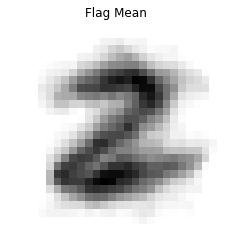

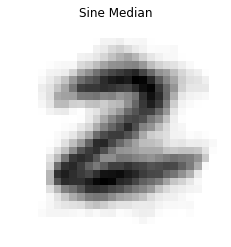

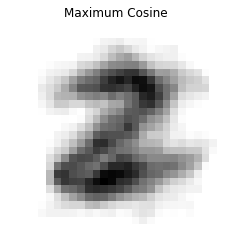

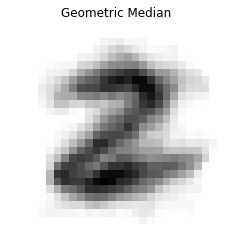

In [52]:
plt.figure()
plt.title('Flag Mean')
plt.imshow(flagmeans[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

plt.figure()
plt.title('Sine Median')
plt.imshow(sin_medians[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

plt.figure()
plt.title('Maximum Cosine')
plt.imshow(max_cosines[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

plt.figure()
plt.title('Geometric Median')
plt.imshow(geo_medians[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

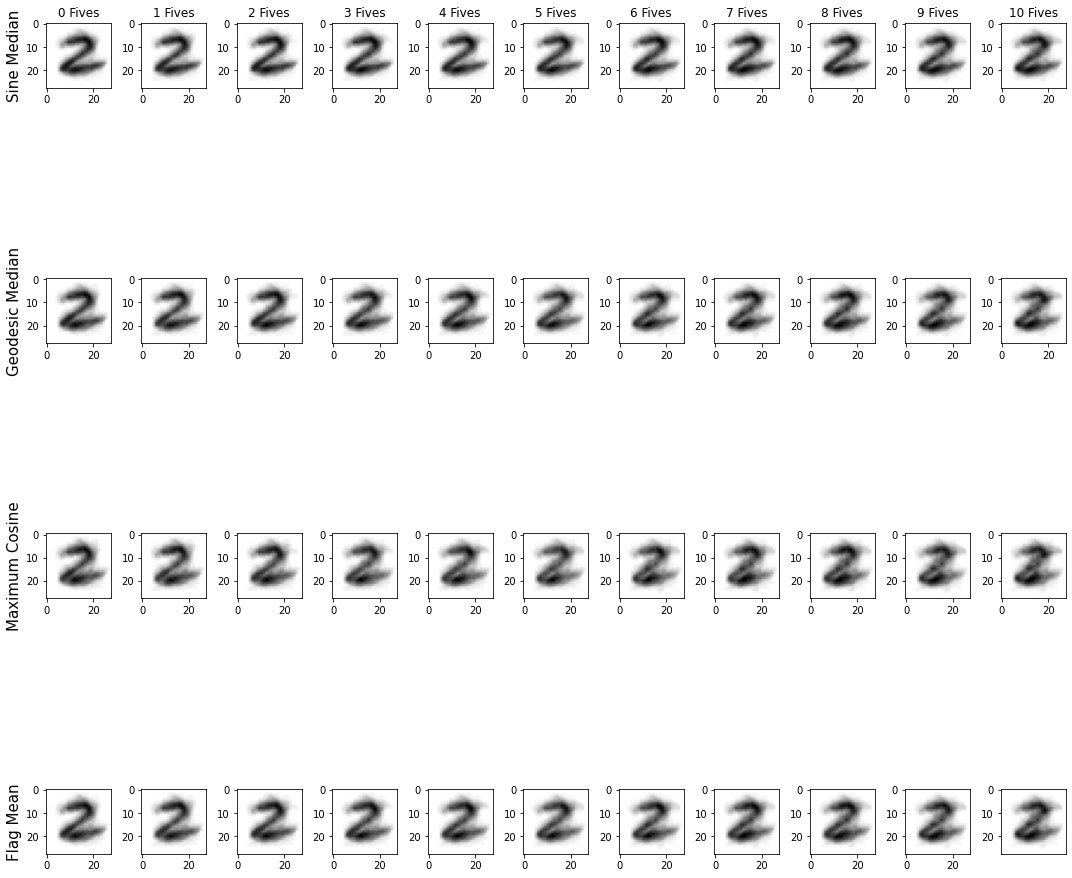

In [50]:
num_tests = num_samples2//incr
fig, axs = plt.subplots(4, 11, figsize=(15,15))

for ii in range(11):

    
#     axs[0,ii].set_title('Sine Median '+str(n2s[ii])+' twos , '+str(n5s[ii])+' fives')
    axs[0,ii].imshow(sin_medians[ii].reshape(28,28), cmap = 'gray')
#     axs[0,ii].axis('off')
    

    
#     axs[1,ii].set_title('Geodesic Median '+str(n2s[ii])+' twos, '+str(n5s[ii])+' fives')
    axs[1,ii].imshow(geo_medians[ii].reshape(28,28), cmap = 'gray')
#     axs[1,ii].axis('off')

#     axs[2,ii].set_title('Maximum Cosine '+str(n2s[ii])+' twos , '+str(n5s[ii])+' fives')
    axs[2,ii].imshow(max_cosines[ii].reshape(28,28), cmap = 'gray')
#     axs[2,ii].axis('off')

#     axs[3,ii].set_title('Flag Mean '+str(n2s[ii])+' twos, '+str(n5s[ii])+' fives')
    axs[3,ii].imshow(flagmeans[ii].reshape(28,28), cmap = 'gray')
#     axs[3,ii].axis('off')




plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelside=False) # labels along the bottom edge are off



cols = [str(ii)+' Fives' for ii in range(11)]
rows = ['Sine Median', 'Geodesic Median', 'Maximum Cosine', 'Flag Mean']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)    


for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size = 15)
    

    
fig.tight_layout()
plt.show()

Sine Median
Maximum Cosine
Geodesic Median
Flag Mean


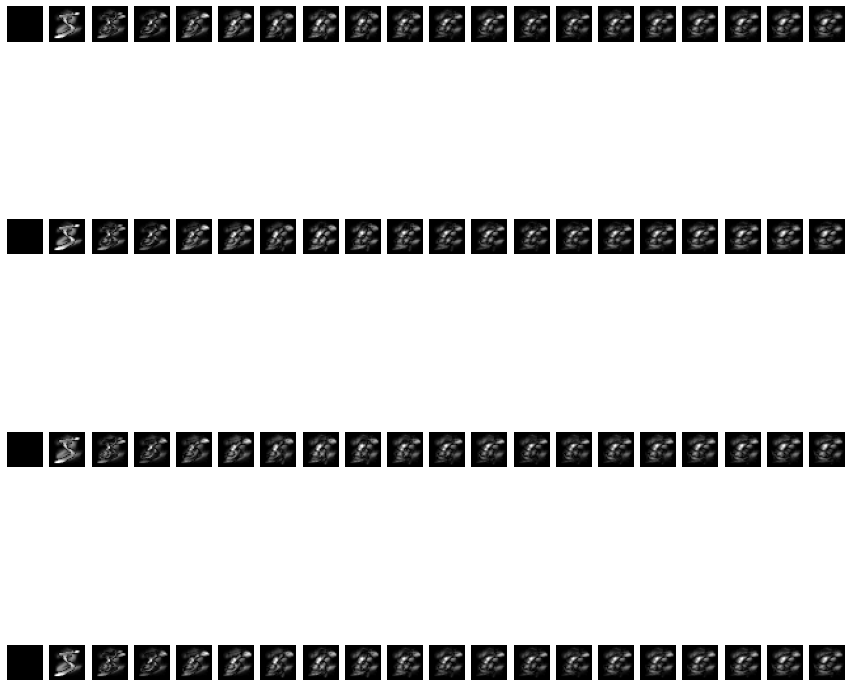

In [27]:
#differences from 0

num_tests = num_samples2//incr
fig, axs = plt.subplots(4, num_tests, figsize=(15,15))
for ii in range(num_tests):
#     axs[0,ii].set_title('Flag Mean '+str(n2s[ii])+' twos, '+str(n5s[ii])+' fives')
    temp = np.abs(flagmeans[ii] - flagmeans[0])
    axs[0,ii].imshow(temp.reshape(28,28), cmap = 'gray')
    axs[0,ii].axis('off')
    
#     axs[1,ii].set_title('Sine Median '+str(n2s[ii])+' twos , '+str(n5s[ii])+' fives')
    temp = np.abs(sin_medians[ii] - sin_medians[0])
    axs[1,ii].imshow(temp.reshape(28,28), cmap = 'gray')
    axs[1,ii].axis('off')
    
#     axs[2,ii].set_title('Maximum Cosine '+str(n2s[ii])+' twos , '+str(n5s[ii])+' fives')
    temp = np.abs(max_cosines[ii] - max_cosines[0])
    axs[2,ii].imshow(temp.reshape(28,28), cmap = 'gray')
    axs[2,ii].axis('off')
    
#     axs[3,ii].set_title('Geodesic Median '+str(n2s[ii])+' twos, '+str(n5s[ii])+' fives')
    temp = np.abs(geo_medians[ii] - geo_medians[0])
    axs[3,ii].imshow(temp.reshape(28,28), cmap = 'gray')
    axs[3,ii].axis('off')
print('Sine Median')
print('Maximum Cosine')
print('Geodesic Median')
print('Flag Mean')



In [ ]:
plot_results('Flag Mean', flagmeans, plot_k, n2s, n5s)

In [ ]:
plot_results('Sine Median', sin_medians, plot_k, n2s, n5s)

In [ ]:
plot_results('Maximum Cosine', max_cosines, plot_k, n2s, n5s)

In [ ]:
for sin_median in sin_medians:
    if not sanity_check(sin_median, 'sine', dataset):
        'Sine Median did not converge to optimizer'
for max_cosine in max_cosines:
    if not sanity_check(max_cosine, 'cosine', dataset):
        'Maximum Cosine did not converge to optimizer'
print('Check finished.')

## Embeddings

In [ ]:

k = 1 #Gr(k,n)
num_samples2 = 10 #number of samples of the 2 digit
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 1 #samples 5s from 0 to num_samples2 in increments of incr

plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS

if num_samples2 % incr != 0:
    print('incr does not divide num_samples2 evenly!')

In [ ]:

flagmeans = []
sin_medians = []
max_cosines = []
geo_medians = []
n2s  = []
n5s = []

for num_samples5 in range(0,num_samples2,incr):
    out = run_test(k,num_samples2,num_samples5,n_its,seed)
    flagmeans.append(out[0])
    sin_medians.append(out[1])
    max_cosines.append(out[2])
    if k == 1:
        geo_medians.append(out[3])
    n2s.append(num_samples2)
    n5s.append(num_samples5)
if k == 1:
    dataset = out[4]
else:
    dataset = out[3]
    

In [ ]:
dataset_and_averages = dataset + sin_medians+geo_medians+max_cosines+flagmeans

n_all_pts = len(dataset_and_averages)

Distances = np.zeros((n_all_pts, n_all_pts))

for i in range(n_all_pts):
    for j in range(i+1, n_all_pts):
        cos = (dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])[0][0]
        if cos > 1:
            cos = 1
        elif cos < 0:
            cos = 0
        Distances[i,j] = np.arccos(np.sqrt(cos))
        Distances[j,i] = Distances[i,j].copy()

In [ ]:
plt.imshow(Distances)

In [ ]:
from sklearn.manifold import MDS

embedding = MDS(dissimilarity = 'precomputed', n_components = 2)
transformed = embedding.fit_transform(Distances)
transformed.shape

In [ ]:
ii=0
for i in range(0,num_samples2, incr):
    
    plt.figure()
    plt.scatter(transformed[:num_samples2,0], transformed[:num_samples2,1], c = '.2')
    plt.scatter(transformed[num_samples2:num_samples2+i,0], transformed[num_samples2:num_samples2+i,1], c = '.2', marker = 'x')
    plt.scatter(transformed[num_samples2*2+ii-1:num_samples2*2+ii,0], transformed[num_samples2*2+ii-1:num_samples2*2+ii,1], marker = '<', c = 'blue', alpha = .5)
    plt.scatter(transformed[num_samples2*3+ii-1:num_samples2*3+ii,0], transformed[num_samples2*3+ii-1:num_samples2*3+ii,1], marker = '<', c = 'orange', alpha = .5)
    plt.scatter(transformed[num_samples2*4+ii-1:num_samples2*4+ii,0], transformed[num_samples2*4+ii-1:num_samples2*4+ii,1], marker = '<', c = 'green', alpha = .5)
    plt.scatter(transformed[num_samples2*5+ii-1:num_samples2*5+ii,0], transformed[num_samples2*5+ii-1:num_samples2*5+ii,1], marker = '<', c = 'red', alpha = .5)
    ii+=1

In [ ]:
for i in range(10):
    plt.figure()
    plt.scatter(transformed[:num_samples2,0], transformed[:num_samples2,1], c = '.2')
    if i > 0:
        plt.scatter(transformed[num_samples2:num_samples2+i,0], transformed[num_samples2:num_samples2+i,1], color = 'purple', alpha = .1*i, marker = 'x')
    plt.plot(transformed[num_samples2+9:num_samples2+9+i+1,0], transformed[num_samples2+9:num_samples2+9+i+1,1], c = 'blue')
    plt.plot(transformed[num_samples2+19:num_samples2+19+i+1,0], transformed[num_samples2+19:num_samples2+19+i+1,1], c = 'orange', linestyle = 'dashed')
    plt.plot(transformed[num_samples2+29:num_samples2+29+i+1,0], transformed[num_samples2+29:num_samples2+29+i+1,1], c = 'green', linestyle = 'dashdot')
    plt.plot(transformed[num_samples2+39:num_samples2+39+i+1,0], transformed[num_samples2+39:num_samples2+39+i+1,1], c = 'red', linestyle = 'dotted')
